In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoProcessor, Blip2ForImageTextRetrieval
from dataset import COCODataset
from awq.quantizer import Blip2ForConditionalGenerationAWQQuantizer
from inference_pipeline import InferencePipeline

import time

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='cuda')

## AWQ Blip-2 Caption Generation

In [5]:
# SETUP
model_name = "Salesforce/blip2-opt-2.7b"
model = Blip2ForConditionalGeneration.from_pretrained(model_name)
model.to(device)

processor = Blip2Processor.from_pretrained(model_name)

# NOTE: set paths as appropriate
# Will sample n_samples from dataset to create calibration set
coco_dataset = COCODataset(ann_file='/nfshomes/vla/project_dirs/low-bit-vision/datasets/cocow/annotations/captions_val2017.json',
                           img_dir='/nfshomes/vla/project_dirs/low-bit-vision/datasets/cocow/images/val2017')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/fs/nexus-scratch/vla/micromamba/envs/MMQ/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [6]:
pipeline = InferencePipeline(model, device, processor)
results = pipeline.run_inference(coco_dataset, task = 'image_captioning', max_samples = 1)
results

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


{'predictions': [{'image_id': 397133,
   'caption': 'a woman in a kitchen with a man in a kitchen'}],
 'references': [['A man is in a kitchen making pizzas.',
   'Man in apron standing on front of oven with pans and bakeware',
   'A baker is working in the kitchen rolling dough.',
   'A person standing by a stove in a kitchen.',
   'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.']]}

In [7]:
# sample config, load from JSON or smth
# model_part: bit_width

config = {}
config['vit_layers'] = {
    'self_attn': 4,
    'self_attn_output':4,
    'fc1': 4,
    'fc2': 4,
}

# config['qformer_layers'] = {
#     'self_attn': 4,
#     'self_attn_output':4,
#     'intermediate_query':4,
#     'output_query': 4,
#     'cross_attn': 4,
#     'cross_attn_output': 4
# }

config['llm_layers'] = {
    'self_attn': 4,
    'self_attn_output':4,
    'fc1':4,
    'fc2':4
}

In [8]:
# Apply AWQ
quantizer = Blip2ForConditionalGenerationAWQQuantizer(model, device, processor, coco_dataset, config)

start = time.time()
quantizer.quantize()
print(f'Quantization time: {time.time() - start:.2f} seconds')

Quantizing llm_layers: 100%|██████████| 32/32 [05:30<00:00, 10.34s/it]

Quantization time: 647.47 seconds


In [9]:
# NOTE:make sure to move model back to device, quantizing moves layers around to save memory 
model.to(device)
pipeline = InferencePipeline(model, device, processor)
results = pipeline.run_inference(coco_dataset, task = 'image_captioning', max_samples = 1)
results

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


{'predictions': [{'image_id': 397133,
   'caption': 'a woman standing in a kitchen with pots and pans on the counter'}],
 'references': [['A man is in a kitchen making pizzas.',
   'Man in apron standing on front of oven with pans and bakeware',
   'A baker is working in the kitchen rolling dough.',
   'A person standing by a stove in a kitchen.',
   'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.']]}

In [13]:
# NOTE: below ran quantizing all parts to 4-bit, i.e config['qformer_layers'] also provided
# NOTE: full AWQ quantization at 4 bits still seems to degrade captions to garbage


config = {}
config['vit_layers'] = {
    'self_attn': 4,
    'self_attn_output':4,
    'fc1': 4,
    'fc2': 4,
}

config['qformer_layers'] = {
    'self_attn': 4,
    'self_attn_output':4,
    'intermediate_query':4,
    'output_query': 4,
    'cross_attn': 4,
    'cross_attn_output': 4
}

config['llm_layers'] = {
    'self_attn': 4,
    'self_attn_output':4,
    'fc1':4,
    'fc2':4
}

# Apply AWQ
quantizer = Blip2ForConditionalGenerationAWQQuantizer(model, device, processor, coco_dataset, config)

start = time.time()
quantizer.quantize()
print(f'Quantization time: {time.time() - start:.2f} seconds')

Quantizing llm_layers: 100%|██████████| 32/32 [05:28<00:00, 10.26s/it]

Quantization time: 658.00 seconds


In [15]:
# NOTE:make sure to move model back to device, quantizing moves layers around to save memory 
model.to(device)
pipeline = InferencePipeline(model, device, processor)
results = pipeline.run_inference(coco_dataset, task = 'image_captioning', max_samples = 1)
results

100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


{'predictions': [{'image_id': 397133, 'caption': 'K, and thes.'}],
 'references': [['A man is in a kitchen making pizzas.',
   'Man in apron standing on front of oven with pans and bakeware',
   'A baker is working in the kitchen rolling dough.',
   'A person standing by a stove in a kitchen.',
   'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.']]}

## AWQ Blip-2 Info-Retrieval

In [17]:
model_name = "Salesforce/blip2-itm-vit-g"
model = Blip2ForImageTextRetrieval.from_pretrained(model_name, torch_dtype=torch.float16)
model.to(device)
processor = AutoProcessor.from_pretrained(model_name)

In [18]:
model

Blip2ForImageTextRetrieval(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((140

In [19]:
from inference_pipeline import InferencePipeline

pipeline = InferencePipeline(model, device, processor)

In [20]:
from dataset import Flickr30kEvalDataset

ann_file = '/nfshomes/vla/project_dirs/low-bit-vision/datasets/flickr30k/annotations/test.json'
img_dir = '/nfshomes/vla/project_dirs/low-bit-vision/datasets/flickr30k/images/flickr30k-images'

dataset = Flickr30kEvalDataset(ann_file, img_dir)


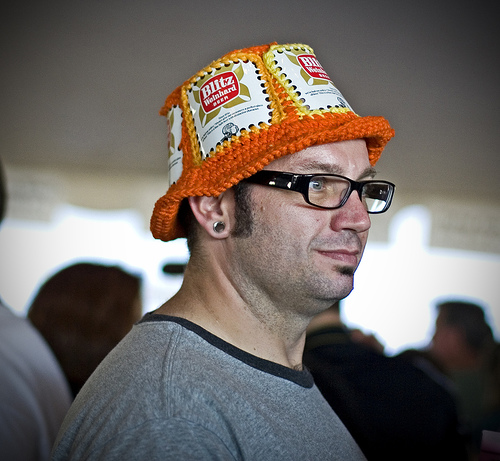

In [21]:
dataset[0]['image']

In [22]:
pipeline.run_inference(dataset, task = 'image_text_retrieval')

/fs/nexus-scratch/vla/micromamba/envs/MMQ/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Getting text embeddings


100%|██████████| 1250/1250 [00:10<00:00, 118.28it/s]


Getting image embeddings


  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'Image' object has no attribute 'unsqueeze'